In [2]:
# %%
from pathlib import Path 
import os
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
from collections import Counter
from napatrackmater.Trackvector import (TrackVector,
                                        SHAPE_FEATURES, 
                                        DYNAMIC_FEATURES, 
                                        SHAPE_DYNAMIC_FEATURES,
                                        
                                        )

/home/debian/miniconda3/envs/kapoorlabsenv/lib/python3.10/site-packages/kornia/feature/lightglue.py:44: FutureWarning: `torch.cuda.amp.custom_fwd(args...)` is deprecated. Please use `torch.amp.custom_fwd(args..., device_type='cuda')` instead.
  @torch.cuda.amp.custom_fwd(cast_inputs=torch.float32)
2024-09-03 20:39:40.572038: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-03 20:39:40.652018: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-09-03 20:39:40.689020: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-09-03 20:39:40.744771: I tensorflow/core/platform/cpu_feature

In [3]:
dataset_name = 'Sixth'
home_folder = '/home/debian/jz/'
timelapse_to_track = f'timelapse_{dataset_name.lower()}_dataset'
tracking_directory = f'{home_folder}Mari_Data_Oneat/Mari_{dataset_name}_Dataset_Analysis/nuclei_membrane_tracking/'
channel = 'nuclei_'
data_frames_dir = os.path.join(tracking_directory, f'dataframes/')
master_xml_name = 'master_' + 'marching_cubes_filled_' + channel + timelapse_to_track + ".xml"
xml_path = Path(os.path.join(tracking_directory, master_xml_name))

goblet_basal_radial_dataframe = os.path.join(data_frames_dir , f'goblet_basal_dataframe_normalized_{channel}predicted.csv')

save_dir = os.path.join(tracking_directory, f'neighbour_plots/')
Path(save_dir).mkdir(exist_ok=True, parents=True)

shape_cols = SHAPE_FEATURES
dynamic_cols = DYNAMIC_FEATURES
feature_cols = SHAPE_DYNAMIC_FEATURES

neighbour_radius_xy = 30 #pixels
neighbour_radius_z = 5


In [4]:
track_vectors = TrackVector(master_xml_path=xml_path)
track_vectors.t_minus = 0
track_vectors.t_plus = track_vectors.tend
track_vectors.y_start = 0
track_vectors.y_end = track_vectors.ymax
track_vectors.x_start = 0
track_vectors.x_end = track_vectors.xmax

tracks_goblet_basal_radial_dataframe = pd.read_csv(goblet_basal_radial_dataframe)

Reading Master XML


In [5]:
neighbour_dataframe = tracks_goblet_basal_radial_dataframe[~tracks_goblet_basal_radial_dataframe['Cell_Type'].isna()]

In [6]:



def find_neighbors_within_radius(df, radius_xy, height_z):
            neighbors_dict = {}
            unique_track_ids = df['Track ID'].unique()
            unique_time_points = df['t'].unique()
            
            for track_id in tqdm(unique_track_ids):
                neighbors_dict[track_id] = {}
                
                for time_point in unique_time_points:
                    # Get the current track's coordinates
                    current_track = df[(df['Track ID'] == track_id) & (df['t'] == time_point)]
                    if current_track.empty:
                        continue
                    
                    current_coords = current_track.iloc[0][['z', 'y', 'x']].values 
                    
                    # Filter DataFrame for the current time point
                    time_filtered_df = df[df['t'] == time_point]
                    
                    # Compute distances using vectorized operations
                    distances_xy = np.sqrt((time_filtered_df['y'] - current_coords[1])**2 + 
                                        (time_filtered_df['x'] - current_coords[2])**2)
                    distances_z = np.abs(time_filtered_df['z'] - current_coords[0])
                    
                    # Apply boolean masks to filter valid indices
                    within_radius_xy = distances_xy <= radius_xy
                    within_height_z = distances_z <= height_z
                    valid_indices = within_radius_xy & within_height_z
                    
                    # Get valid track IDs, excluding the current track ID
                    valid_track_ids = time_filtered_df[valid_indices]['Track ID'].unique()
                    valid_track_ids = valid_track_ids[valid_track_ids != track_id]
                    
                    # Get neighbor cell types
                    neighbor_cell_types = time_filtered_df[time_filtered_df['Track ID'].isin(valid_track_ids)]['Cell_Type'].tolist()
                    neighbors_dict[track_id][time_point] = neighbor_cell_types
            
            return neighbors_dict

In [7]:
neighbors_dict = find_neighbors_within_radius(neighbour_dataframe, neighbour_radius_xy, neighbour_radius_z)

  0%|          | 0/870 [00:00<?, ?it/s]

100%|██████████| 870/870 [12:09<00:00,  1.19it/s]


In [8]:
color_palette = {
    'Basal': '#1f77b4',  
    'Radial': '#ff7f0e',
    'Goblet': '#2ca02c',
}

def plot_for_all_timepoints(df, neighbors_dict, window_size=10):
    timepoints = sorted(df['t'].unique())
    all_cell_type_types = {cell_type: {tp: Counter() for tp in timepoints} for cell_type in df['Cell_Type'].unique()}
    cell_type_totals = {cell_type: {tp: 0 for tp in timepoints} for cell_type in df['Cell_Type'].unique()}

    # Calculate neighbor counts and total counts
    for time_point in timepoints:
        time_filtered_df = df[df['t'] == time_point]
        total_counts = time_filtered_df['Cell_Type'].value_counts().to_dict()
        for track_id in time_filtered_df['Track ID'].unique():
            track_data = time_filtered_df[time_filtered_df['Track ID'] == track_id].iloc[0]
            current_cell_type = track_data['Cell_Type']
            neighbors = neighbors_dict.get(track_id, {}).get(time_point, [])
            neighbor_counts = Counter(neighbors)

            if current_cell_type in all_cell_type_types:
                all_cell_type_types[current_cell_type][time_point] += neighbor_counts
                cell_type_totals[current_cell_type][time_point] = total_counts.get(current_cell_type, 0)

    # Normalize neighbor counts
    normalized_cell_type_types = {}
    for cell_type in all_cell_type_types:
        normalized_cell_type_types[cell_type] = {}
        for time_point in all_cell_type_types[cell_type]:
            total_count = cell_type_totals[cell_type][time_point]
            if total_count > 0:
                normalized_counts = {k: v / total_count for k, v in all_cell_type_types[cell_type][time_point].items()}
            else:
                normalized_counts = all_cell_type_types[cell_type][time_point]
            normalized_cell_type_types[cell_type][time_point] = normalized_counts

    # Apply rolling window average
    smoothed_cell_type_types = {}
    for cell_type in normalized_cell_type_types:
        smoothed_cell_type_types[cell_type] = {}
        for neighbor in sorted(set(neigh for counts in normalized_cell_type_types[cell_type].values() for neigh in counts)):
            y_values = [normalized_cell_type_types[cell_type].get(tp, {}).get(neighbor, 0) for tp in timepoints]
            y_smoothed = pd.Series(y_values).rolling(window=window_size, min_periods=1).mean().tolist()
            smoothed_cell_type_types[cell_type] = smoothed_cell_type_types.get(cell_type, {})
            smoothed_cell_type_types[cell_type][neighbor] = y_smoothed

    # Plotting
    fig, axs = plt.subplots(len(normalized_cell_type_types), 1, figsize=(16, len(normalized_cell_type_types) * 6))
    if len(normalized_cell_type_types) == 1:
        axs = [axs]

    for idx, cell_type in enumerate(smoothed_cell_type_types):
        ax = axs[idx]
        neighbor_types = sorted(smoothed_cell_type_types[cell_type].keys())

        for neighbor in neighbor_types:
            y_values = smoothed_cell_type_types[cell_type][neighbor]
            ax.plot(timepoints, y_values, label=f'{neighbor}', color=color_palette.get(neighbor, 'grey'), marker='o')

        ax.set_title(f'Rolling Average of Neighbor Counts for Cell Type: {cell_type}')
        ax.set_xlabel('Timepoint')
        ax.set_ylabel('Normalized Count (Rolling Average)')
        ax.legend(loc='upper right')
        ax.grid(True)

    plt.tight_layout()
    fig.savefig(os.path.join(save_dir, f'radius_{neighbour_radius_xy}_{neighbour_radius_z}_rolling_avg_neighbor_counts.png'))
    plt.show()



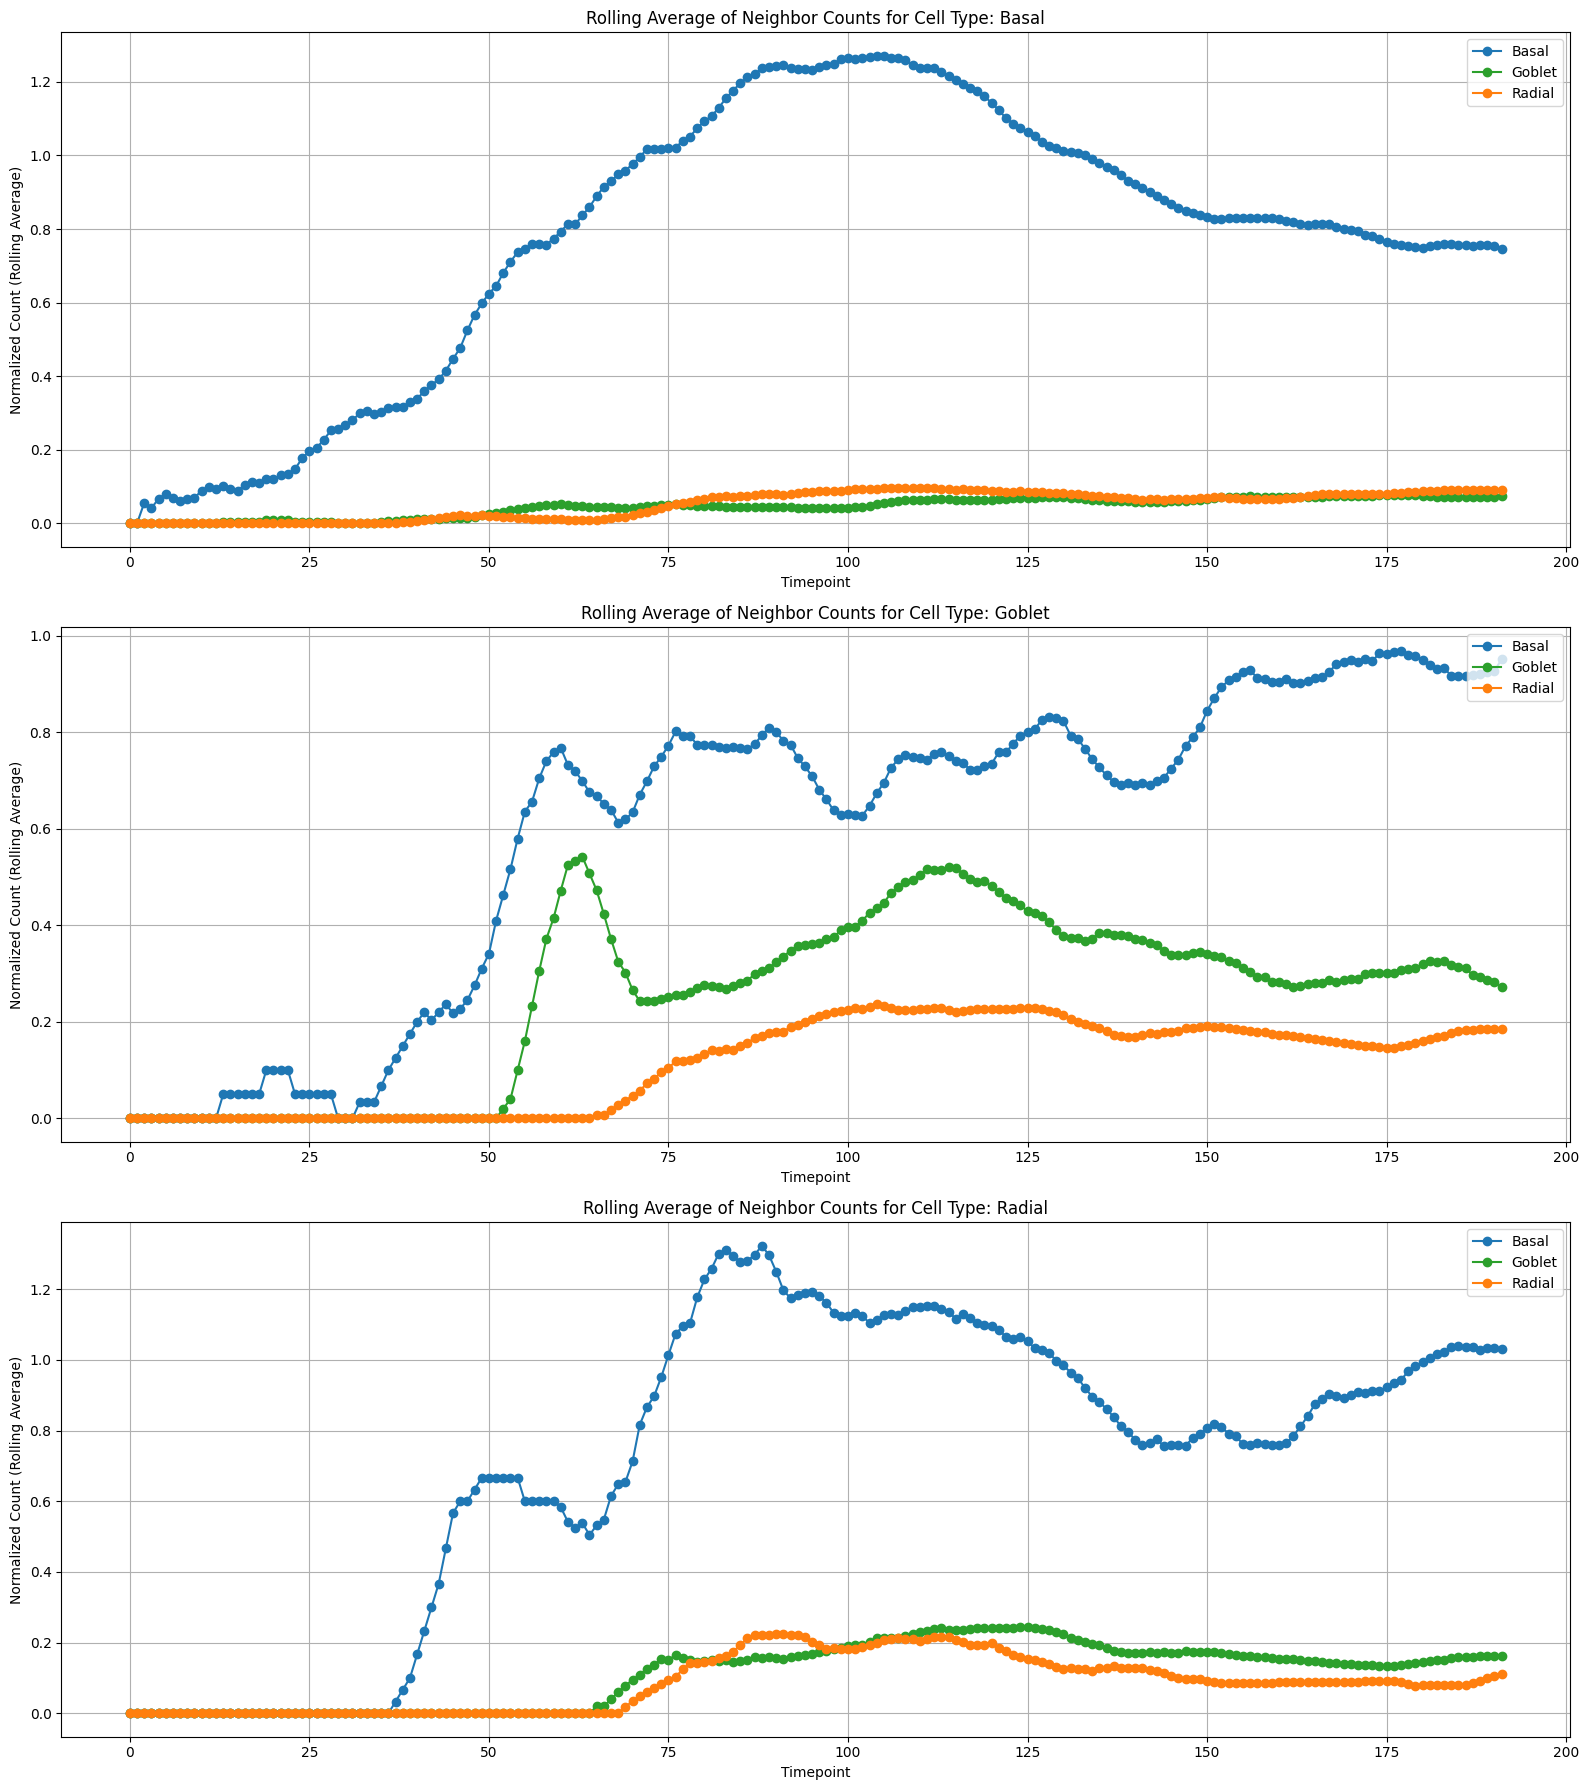

In [9]:
plot_for_all_timepoints(neighbour_dataframe, neighbors_dict)